<a href="https://colab.research.google.com/github/alexrafkin/houseprice_regression/blob/main/MakingPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn import linear_model
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [ ]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices['neighborhood'])], axis=1, sort=False)
prices = houseprices[['saleprice', 'overallqual','grlivarea','garagecars','firstflrsf','NoRidge']]
prices[['exterqual_Ex','exterqual_Fa','exterqual_Gd','exterqual_TA']] = pd.get_dummies(houseprices['exterqual'])
log_list = ['firstflrsf','grlivarea','saleprice']
for col in log_list:
  prices['log_{}'.format(col)] = np.log(prices[col])
prices = prices.drop(['firstflrsf','grlivarea','exterqual_Fa'], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# `Y` is the target variable
Y = prices['saleprice']
# `X` is the feature set which includes the
# `is_male` and `is_smoker` variables
X = prices[['overallqual','garagecars','log_firstflrsf','log_grlivarea','exterqual_Ex']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [ ]:
X_train = sm.add_constant(X_train)
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     757.3
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:34   Log-Likelihood:                -13979.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1162   BIC:                         2.800e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.663e+05   3.32e+04    -20.

R^2 terms are around 0.765, which is pretty good. F-stat is high w 0 p-val, and AIC&BIC are both high. Seems like a pretty good fit without overfitting.

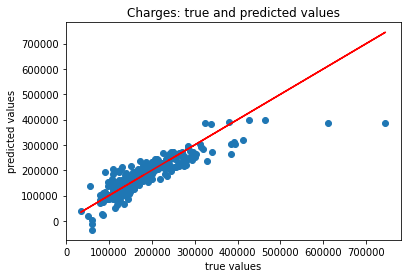

Mean absolute error of the prediction is: 27057.808040028
Mean squared error of the prediction is: 1722181062.851061
Root mean squared error of the prediction is: 41499.16942362896
Mean absolute percentage error of the prediction is: 16.857477440467484


In [ ]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

It predicts the lower priced houses well, but then the predicted prices level off - these very expensive houses might have unattributed factors - possibly neighborhood or features like a pool. The MAPE looks pretty good, as does MAE. I would say this model is satisfactory for lower priced homes.

In [ ]:
Y2 = prices['saleprice']
# `X` is the feature set which includes the
# `is_male` and `is_smoker` variables
X2 = prices[['overallqual','garagecars','log_firstflrsf','log_grlivarea','exterqual_Ex','exterqual_TA','exterqual_Gd']]
X2['qual*area'] = X2.overallqual * X2.log_grlivarea
X2['exterqual_Ex*cars'] = X2.garagecars * X2.exterqual_Ex

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X2_train.shape[0]))
print("The number of observations in test set is {}".format(X2_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X2_train = sm.add_constant(X2_train)
# Fit an OLS model using statsmodels
results2 = sm.OLS(y2_train, X2_train).fit()

# Print the summary results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     533.9
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:09:31   Log-Likelihood:                -13868.
No. Observations:                1168   AIC:                         2.776e+04
Df Residuals:                    1158   BIC:                         2.781e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.813e+05    8.9e+0

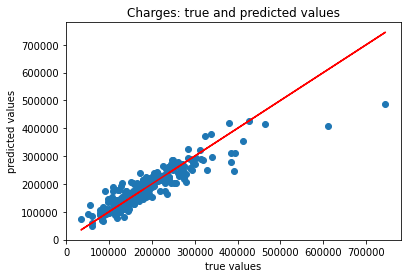

Mean absolute error of the prediction is: 23225.612033300084
Mean squared error of the prediction is: 1232319960.1320283
Root mean squared error of the prediction is: 35104.41510881542
Mean absolute percentage error of the prediction is: 13.770636745762467


In [ ]:
# Add a constant to the model because it's best practice
# to do so every time!
X2_test = sm.add_constant(X2_test)

# You are making predictions here
y2_preds = results2.predict(X2_test)

plt.scatter(y2_test, y2_preds)
plt.plot(y2_test, y2_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

By adding some interaction terms and the other exterqual classifiers, we have made minor improvements on our predictions.